# Monte Carlo

In [1]:
import numpy as np
import random
import networkx as nx
import osmnx as ox

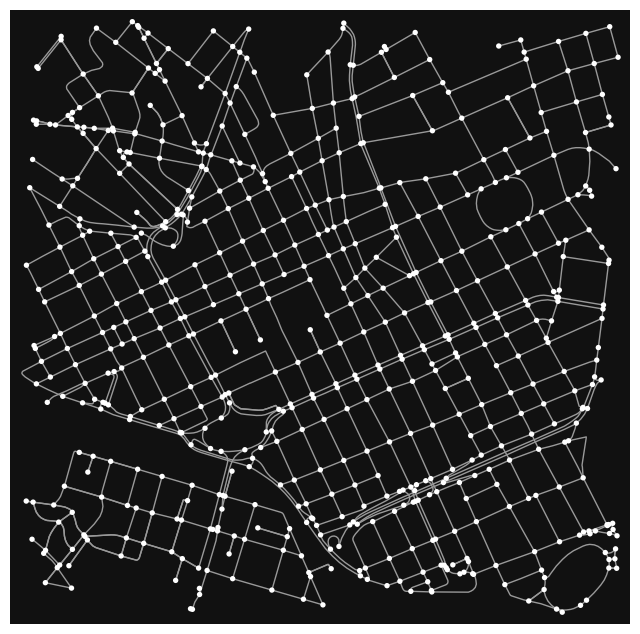

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)

In [3]:
class Environment:
  """
  Simulation of graph route that can be deterministic and stochastic.
  The main functionalities is to reset the simulation and returns the state based in the action.
  """

  def __init__(self, G, source, target, reward="weighted", mode="deterministic"):
    self.G = G
    self.source = source
    self.target = target
    self.reward = reward
    if mode == "deterministic":
        self.step = self.step_deterministic
    elif mode == "stochastic":
        self.step = self.step_stochastic

  def get_n_states(self):
    """Get number of states"""
    return len(self.G.nodes)

  def reset(self):
    """Return to the source state that is not the destination"""
    self.state = self.source
    # self.state = np.random.choice(list(self.G.nodes))
    # while self.state == self.target:
        # self.state = np.random.choice(list(self.G.nodes))
    return self.state

  def step_deterministic(self, action):
    """Return new state, reward, and if the destination is reached"""

    # if is not the target, and the action is to stay in the same node
    if (action == self.state) & (action != self.target):
      return self.state, -1, False

    # if reached the target
    if self.state == self.target:
      return self.state, 10000, True

    
    # weight of the edge
    w = self.G[self.state][action][0]["length"]
    # now, the state is the next node
    self.state = action

    # if the state reached the target

    if self.reward == "unit":
        return self.state, 0, False
    elif self.reward == "weighted":
        return self.state, -w, False

In [4]:
def argmax(Q, s):
  """Function to get the action with the highest value in a given state"""
  # pares estado-ação que tem estado = s
  pares = list(filter(lambda step: step[0] == s, list(Q.keys())))
  sub_Q = {k:v for k,v in Q.items() if k in pares}

  top_value = float("-inf")
  ties = []

  for i in sub_Q.items():
      # if a value in q_values is greater than the highest value update top
      if i[1] > top_value:
        top_value = i[1]

  # if a value is equal to top value add to ties
  ties = list(filter(lambda step: step[1] == top_value, list(sub_Q.items())))

  if len(ties)> 0:
    # chose the random index of the ties
    chosen = np.random.choice(range(len(ties)))
  else:
    return 0, False

  return ties[chosen][0][1], True

In [24]:
class MCAgent:
  def __init__(
      self, 
      env, 
      gamma=0.99, 
      n_episodes=1000, 
      max_steps=1000, 
      seed = 42
    ):
    self.env = env
    self.Q = {}
    self.gamma = gamma
    self.n_episodes = n_episodes
    self.max_steps = max_steps
    self.max_epsilon = 1
    self.min_epsilon = 0.1
    self.epsilon = self.max_epsilon
    self.seed = seed
    self.set_seed()
    self.policy = {}
    self.routes = []

  def update_epsilon(self):
    # make it decay exponentially
    self.epsilon -= (self.max_epsilon - self.min_epsilon )/ self.n_episodes

  def set_seed(self):
    random.seed(self.seed)
    np.random.seed(self.seed)


  def step(self, state):
    """Returns the next action epsilon greedily using value function."""
    if np.random.uniform(0, 1) < self.epsilon: # explore
      neighbors = list(self.env.G.neighbors(state)) + [state]
      return random.choice(neighbors)
    else: # exploit
      action, got_it = argmax(self.Q, state)
      if got_it is False: # if not possible to chose the best action, chose randomly
        neighbors = list(self.env.G.neighbors(state)) + [state]
        return random.choice(neighbors)
      else: 
        return int(action)

  def generate_episode(self, observation):
    """Returns the list with state, action and rewards of the episode"""
    # it initializes list of tuples (state, action and reward)
    episode = []
    state = observation
    
    for step in range(self.max_steps):
      action = self.step(state) # select an action
      new_state, reward, reached = self.env.step(action) # take action      
      episode.append((state, action, reward))
      state = new_state

      if reached is True: # if reached the target, break
        self.routes = []
        route = [observation] + [i[1] for i in episode]
        if len(route) > 5:
          print(f"Reached in route of size {len(route)}")
        else:
          print(f"Reached {route}")
          break

        self.routes.append([route])
        break

    self.evaluation(episode)
    return episode


  def evaluation(self, episode):
    G = 0

    for i in range(0, len(episode)-1):
      # state, action, reward
      s, a, r = episode[i]
      _, _, r_t1 = episode[i+1]

      # G <- gamma * G + R(t+1)
      G = (self.gamma * G) +  r_t1


      find_sa_pair = len(list(filter(lambda step: step[0] == s and step[1] == a, episode[i+1:]))) > 0

      # check if s,a are the first visit
      if find_sa_pair is False:
        r_ = self.returns.get((s,a))
        if r_ is None:
          self.returns.update([((s,a), [G])])
        else:
          r_.append(G)
          self.returns.update([((s,a), r_)])

    for i,j in list(self.returns.items()):
      valor = np.sum(j)/len(j)
      self.Q.update([((i[0], i[1]), valor)])
    return 

  def train(self):
    self.epsilon = self.max_epsilon
    self.episode_rewards = []
    self.returns = {}
    for _ in range(self.n_episodes):
      observation = self.env.reset()
      episode = self.generate_episode(observation)
      self.episode_rewards.append(np.sum([i[2] for i in episode]))
      self.update_epsilon()

In [25]:
seeds = [960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534]
np.random.seed(seeds[0])
source = np.random.choice(list(G.nodes))
target = np.random.choice(G.nodes)

print(f"The source is {source} and the target is {target}")
# You need to fix seed again after np.random method
np.random.seed(seeds[1])

env = Environment(G, source, target, "unit", "deterministic")
agent = MCAgent(env)

The source is 507 and the target is 235


In [26]:
agent.train()

Reached in route of size 329
Reached in route of size 339
Reached in route of size 365
Reached in route of size 306
Reached in route of size 570


In [28]:
import matplotlib.pyplot as plt

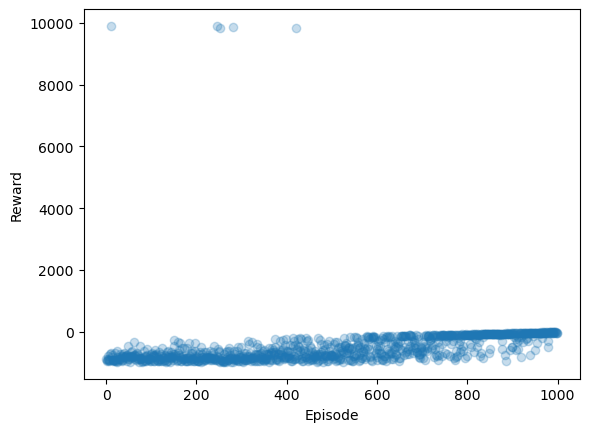

In [29]:
plt.scatter(list(range(len(agent.episode_rewards))), agent.episode_rewards, alpha = 0.25)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()